## G - Simulator and Graphical models

Authors: Noemi Anau Montel, James Alvey, Christoph Weniger

Last update: 15 September 2023

**Purpose**: Introducing the `swyft.Simulator` object, which allows to define and run complex simulation models.

**Key take-away messages**: understand the `build` method of the swyft simulator, which allows us to define a computational graph and generate samples. 

### Code

In [1]:
import numpy as np
import swyft
import pylab as plt
import torch
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [2]:
torch.manual_seed(0)
np.random.seed(0)

A `swyft.Simulator` object can be used to define the computational graph of the physical simulator.  Below, we will show a simulator that corresponds to our above linear regression problem.  We can write the full statistical model as
$$
p(\mathbf x, \mathbf m, \mathbf z) = p(\mathbf x|\mathbf m) p(\mathbf m| \mathbf z) p(\mathbf z)\;,
$$
where the prior for $\mathbf z$ is the uniform distribution
$$
p(\mathbf z) = \mathcal{U}(\mathbf z| -1, 1)\;,
$$
the model predictions are deterministic
$$
p(\mathbf m|\mathbf z) = \delta (\mathbf m - z_1 - z_2\mathbf y - z_3 \mathbf y^2)
$$
and we have Gaussian measurement noise
$$
p(\mathbf x|\mathbf m) = \mathcal{N}(\mathbf x| \mathbf m, \sigma^2 = 0.1^2)
$$

In general, this computational graph might involve sampling from various priors, performing intermediate calculations, simulating instrumental effects and adding measurement noise, etc.

In [3]:
class Simulator(swyft.Simulator):
    def __init__(self, Nbins = 100, sigma = 0.2):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.y = np.linspace(-1, 1, Nbins)
        self.sigma = sigma

    def calc_m(self, z):
        m = np.ones_like(self.y)*z[0] + self.y*z[1] + self.y**2*z[2]
        return m

    def build(self, graph):  # the print statements are for illustration only
        print("--- Building graph!")
        z = graph.node('z', lambda: np.random.rand(3)*2 - 1)
        m = graph.node('m', self.calc_m, z)
        x = graph.node('x', lambda m: m + np.random.randn(self.Nbins)*self.sigma, m)
        print("--- x =", x)
        print("--- m =", m)
        print("--- z =", z)

Once defined, the simulator objects can be flexibly used to perform simulations of the full model or over subcomponents of the model. For instance, samples can be generated through the `sample` method.

In [4]:
sim = Simulator()
samples = sim.sample(10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

--- Building graph!
--- x = Node('x', <function Simulator.build.<locals>.<lambda> at 0x16c453940>, (Node('m', <bound method Simulator.calc_m of <__main__.Simulator object at 0x16c458f70>>, (Node('z', <function Simulator.build.<locals>.<lambda> at 0x16c4539d0>, ()),)),))
--- m = Node('m', <bound method Simulator.calc_m of <__main__.Simulator object at 0x16c458f70>>, (Node('z', <function Simulator.build.<locals>.<lambda> at 0x16c4539d0>, ()),))
--- z = Node('z', <function Simulator.build.<locals>.<lambda> at 0x16c4539d0>, ())


The above output indicates that although multiple samples were generated, the `build` method only ran once at the beginning.  In fact, its purpose is not to perform calculations, but to build the computational graph. This computational graph is then used to generate all samples. Those samples look as expected

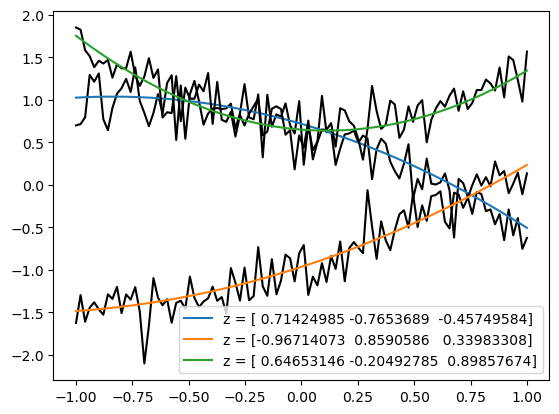

In [5]:
for i in [5, 2, 101]:
    plt.plot(sim.y, samples['x'][i], color='k')
    plt.plot(sim.y, samples['m'][i], label = "z = "+str(samples['z'][i]))
plt.legend();

Let's have a closer look at the build method that we used above.

```python
def build(self, graph): 
    z = graph.node('z', lambda: np.random.rand(3)*2 - 1)
    m = graph.node('m', self.calc_m, z)
    x = graph.node('x', lambda m: m + np.random.randn(self.Nbins)*self.sigma, m)
```

The build method has to be written by the user.  It takes as argument `graph`, which is commonly an empty graph generated by the `swyft.Simulator` class when first running the simulator, just before invoking `build`. This graph is then populated with computational nodes by invoking the `node` method. The first argument of the `node` method is the name of the parameter, the second argument is the function that is invoked to calculate that parameter, and optional additional arguments would be passed directly to that function. The output of the `node` method is a pointer to that computational node, which can be used as input for other nodes, as it is done above.  The populated `graph` is the stored as part of the simulator instance and used for all subsequent calculations.

The `swyft.Simulator` class supports a wide range of computations that one typically encounters in practical applications.  For instance, it is possible to only run parts of the computational graph, by specifying simulation targets.

In [6]:
print(sim.sample(targets = ['z']).keys())  # Generates only samples from the prior
print(sim.sample(targets = ['m']).keys())  # Generates samples from m, and of all variables that appear upstream in the computational graph of m
print(sim.sample(targets = ['x']).keys())  # Generates samples from x, and of all variables that appear upstream in the computational graph of x

dict_keys(['z'])
dict_keys(['z', 'm'])
dict_keys(['z', 'm', 'x'])


Or we can generate samples that are conditioned on certain variables, e.g.:

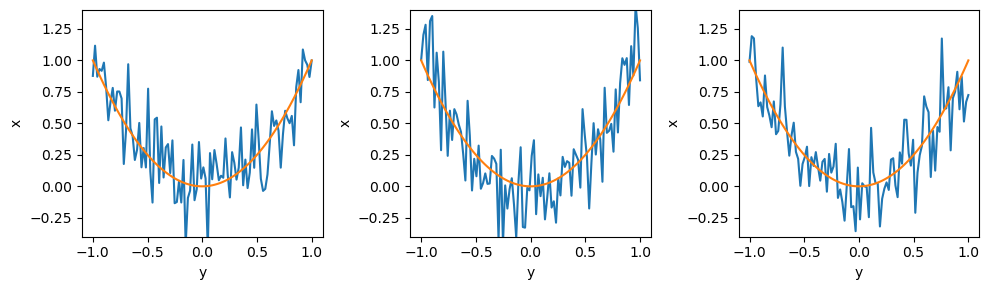

In [7]:
fig = plt.figure(figsize=(10, 3))
for i in range(3):
  ax = plt.subplot(1, 3, i + 1)
  sample = sim.sample(conditions = {'z': np.array([0, 0, 1])})
  plt.plot(sim.y, sample['x']);
  plt.plot(sim.y, sample['m']);
  plt.xlabel('y')
  plt.ylabel('x')
  plt.ylim(-0.4, 1.4)
plt.tight_layout()

When conditioning variables, the dependency on upstream variables disappears. In the below example, `z` is not sampled because `m` is already specified.

In [8]:
sim.sample(conditions = {'m': np.zeros(100)}, targets = ['x']).keys()

dict_keys(['m', 'x'])

### Exercises

1. Turn the noise parameter $\sigma$ into another model parameter, with a uniform prior between zero and one. The noise parameter should have the name 'sigma', and has to be a vector of length one.

In [9]:
# Your simulator goes here|

2. Write an inference network that estimates both the three components of $\mathbf z$ as well as the one component of $\sigma$ (using two LogRatioEstimator instances).

In [10]:
# Your code goes here